In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns
import os
from common import *
import cv2
from sklearn.model_selection import cross_val_score
from sklearn import linear_model as sk
#from mpl_toolkits.mplot3d import Axes3D
#from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn import linear_model as lm

from sklearn.preprocessing import MinMaxScaler
from typing import Tuple

rescale_factor = 0.2


## Methods:

In [6]:
def create_img_patches(img, ySteps, xSteps):
    patches = []
    for y in range(0,img.shape[0], ySteps):
        for x in range(0,img.shape[1], xSteps):
            y_from = y; 
            y_to = y+ySteps; 
            x_from = x; 
            x_to = x+xSteps; 
            img_patch = img[y_from:y_to, x_from:x_to]        
            patches.append(img_patch)

    return patches

def patches_to_img(patches, ySteps, xSteps, nYpatches, nXpatches, plotImage=False):
    img = np.zeros((ySteps*nYpatches, xSteps*nXpatches))
    i = 0
    for y in range(0,img.shape[0], ySteps):
        for x in range(0,img.shape[1], xSteps):
            y_from = y; 
            y_to = y+ySteps; 
            x_from = x; 
            x_to = x+xSteps; 
            img[y_from:y_to, x_from:x_to] = patches[i]         
            i += 1
    
    if plotImage:
        plt.imshow(img, cmap='gray')
        plt.title("Reconstructed img")
        plt.show()
    return img

def plotTerrainPatches(patches, nYpatches, nXpatches, plotTitle="Terrain patches"):
    # Plotting terrain patches
    fig, ax = plt.subplots(nYpatches, nXpatches,figsize=(4,8))
    i=0
    for y in range(nYpatches):
        for x in range(nXpatches):
            ax[y,x].title.set_text(f"Patch{i}")
            ax[y,x].set_xlabel("X"); ax1.set_ylabel("Y")
            ax[y,x].imshow(patches[i], cmap='gray')
            i+=1
    
    fig.suptitle(f"{plotTitle}") # or plt.suptitle('Main title')
    plt.tight_layout()
    plt.savefig(f"{REPORT_FIGURES}{EX6}{plotTitle}.pdf")
    plt.show()

def createTerrainData(terrain, includeMeshgrid=True):
    z = np.array(terrain) 
    x = np.arange(0, z.shape[1])
    y = np.arange(0, z.shape[0])
    if includeMeshgrid:
        x, y = np.meshgrid(x,y)
    return x,y,z


## Load the terrain:


In [7]:
terrain1_file = "SRTM_data_Norway_1.tif"
terrain2_file = "SRTM_data_Norway_2.tif"
terrain1 =  imread(f'{INPUT_DATA}{terrain1_file}')
terrain2 = imread(f'{INPUT_DATA}{terrain2_file}')

rescale_factor = 0.1
ySize = int(terrain1.shape[0] * rescale_factor); print(ySize)
xSize = int(terrain1.shape[1] * rescale_factor); print(xSize)
terrain1Resized = cv2.resize(terrain1, (xSize, ySize))
terrain2Resized = cv2.resize(terrain2, (xSize, ySize))

nXpatches = 3; nYpatches=6
y_steps = int(terrain2Resized.shape[0] / nYpatches); print(y_steps)
x_steps = int(terrain2Resized.shape[1] / nXpatches); print(x_steps)
patches_1 = create_img_patches(terrain1Resized, y_steps, x_steps)

patches_2 = create_img_patches(terrain2Resized, y_steps, x_steps)

img1 = patches_1[1]
img2 = patches_2[3]
x1, y1, z1 = createTerrainData(img1)
x2, y2, z2 = createTerrainData(img2)

scaler1 = MinMaxScaler()
scaler1.fit(img1)
img1_normalized = scaler1.transform(img1)
norm_var1 = np.round(np.var(img1_normalized),decimals=4)

scaler2 = MinMaxScaler()
scaler2.fit(img2)
img2_normalized = scaler1.transform(img2)
norm_var2 = np.round(np.var(img2_normalized),decimals=4)

terrain_data = 2

if terrain_data == 1: # Choosing terrain1
    x, y, z = x1, y1, z1.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z1

elif terrain_data == 2: # Choosing terrain2
    x, y, z = x2, y2, z2.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z2


360
180
60
60


## Cross-Validation:

(3600, 3)


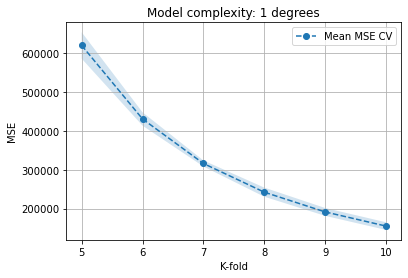

(3600, 6)


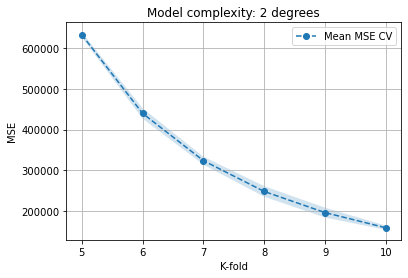

(3600, 10)


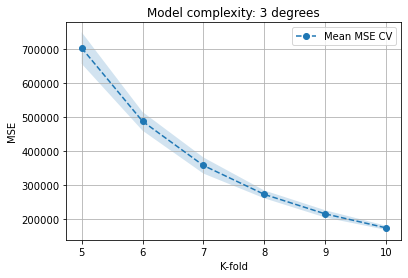

(3600, 15)


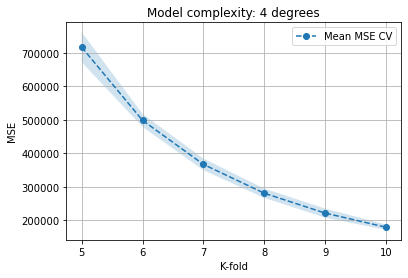

(3600, 21)


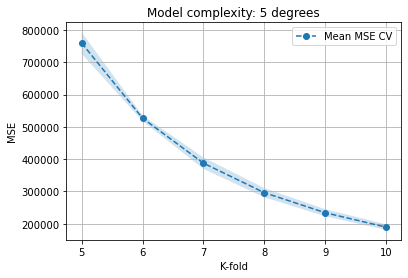

(3600, 28)


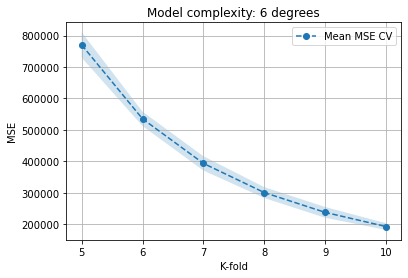

(3600, 36)


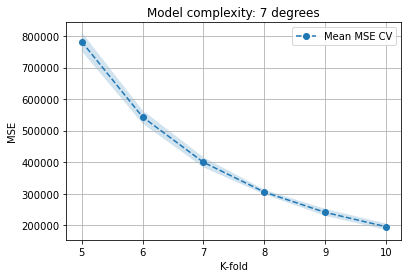

(3600, 45)


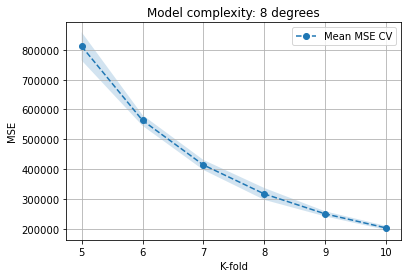

(3600, 55)


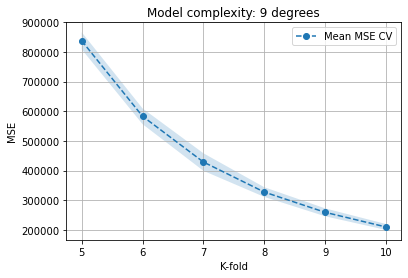

In [8]:

SEED_VALUE = np.random.seed(4155)
z_flat = z.ravel().reshape(-1,1); 
z_flat = z_flat.reshape(-1,1)


for degree in range(1,10):
    X = create_X(x,y,degree)
    #remove intercept: 
    X = X[:,1:]


    mean_folds_error = np.zeros(6)
    mean_folds_error_sk = np.zeros(6)

    mse_std_arr = np.zeros(6)
    for folds in range(5,11):
        

        implemented_scores = cross_val_ex6(k = folds, model = "OLS", X = X, z = z, degree=degree, shuffle=True)
        mean_folds_error[folds-5] = np.mean(implemented_scores)
        mse_std_arr[folds-5] = np.std(implemented_scores)

    plt.plot(np.arange(5,11), mean_folds_error, "o--",  label = "Mean MSE CV")
    plt.fill_between(np.arange(5,11), mean_folds_error-mse_std_arr, mean_folds_error+mse_std_arr,  alpha = 0.2)
    plt.title(f"Model complexity: {degree} degrees")
    plt.xlabel("K-fold")
    plt.ylabel("MSE")
    #plt.ylim(0,2)
    plt.xticks(np.arange(5,11))
    plt.grid(True)
    plt.legend()
    plt.savefig(f"{REPORT_FIGURES}{EX6}mse_cv_boot{degree}.pdf")

    plt.show()
